In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\jackw\AppData\Local\Temp\ipykernel_23408\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by((measurement.date.desc())).first()
print(recent_date)

('2017-08-23',)


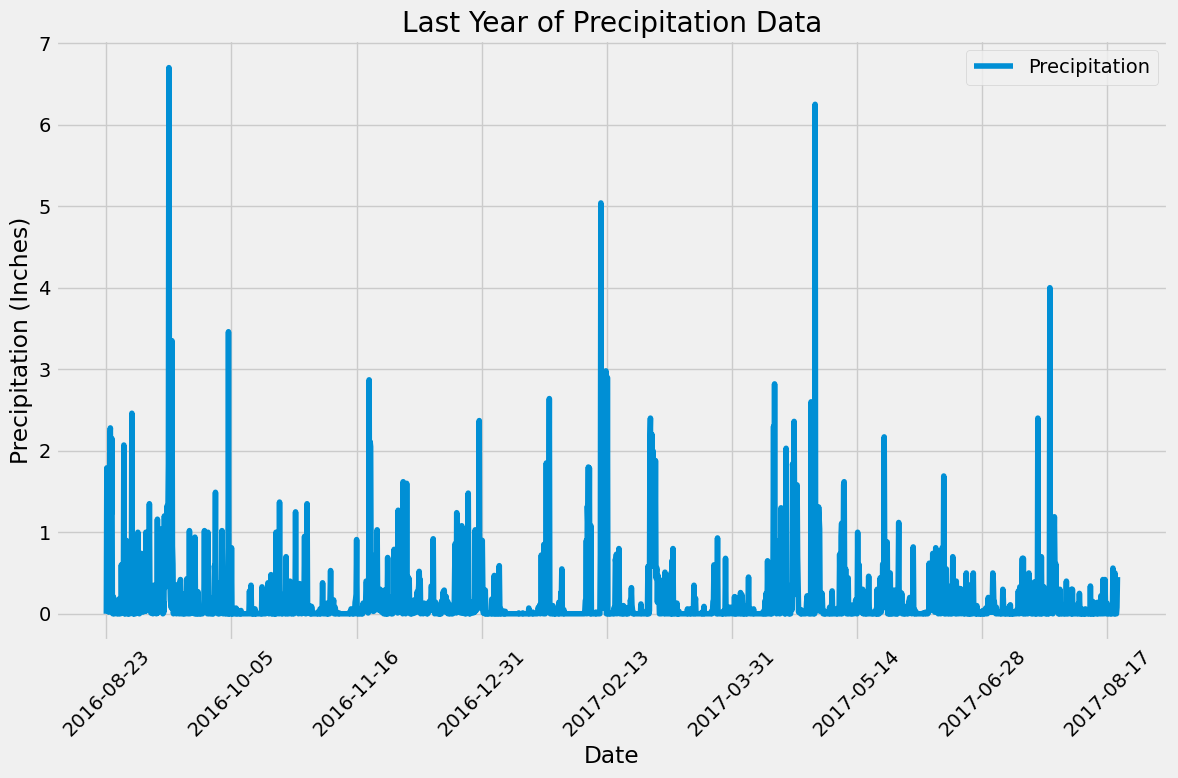

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago_date = dt.date(2017,8,23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp)\
                            .filter(measurement.date >= year_ago_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation']).set_index('Date')

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date').dropna()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize = (12,8), rot = 90)
plt.title('Last Year of Precipitation Data')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
stationcount = session.query(station).count()
stationcount

9

In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station).label('station_count'))\
                        .group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

for station, count in active_stations:
    print(f"Station: {station}, Row Count: {count}")

Station: USC00519281, Row Count: 2772
Station: USC00519397, Row Count: 2724
Station: USC00513117, Row Count: 2709
Station: USC00519523, Row Count: 2669
Station: USC00516128, Row Count: 2612
Station: USC00514830, Row Count: 2202
Station: USC00511918, Row Count: 1979
Station: USC00517948, Row Count: 1372
Station: USC00518838, Row Count: 511


In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
temperature_stats = session.query(func.min(measurement.tobs).label('min_temperature'),
                                  func.max(measurement.tobs).label('max_temperature'),
                                  func.avg(measurement.tobs).label('avg_temperature'))\
                           .filter(measurement.station == most_active_station)\
                           .all()

# Print the results
min_temp, max_temp, avg_temp = temperature_stats[0]
print({min_temp}, {max_temp}, {avg_temp})

{54.0} {85.0} {71.66378066378067}


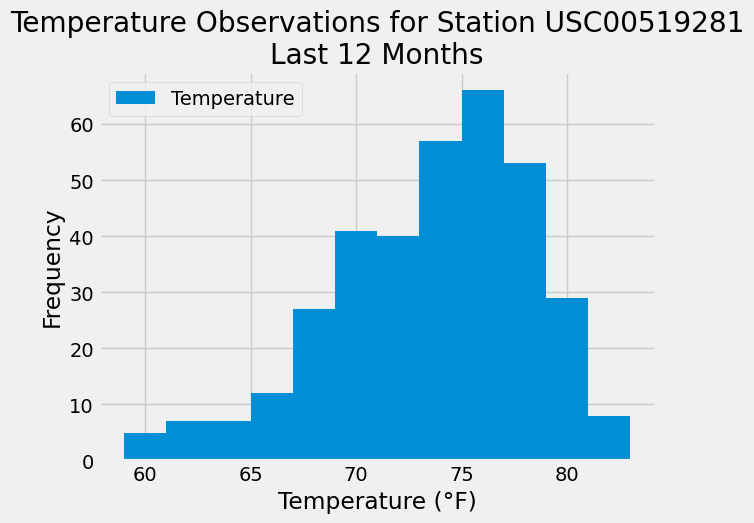

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.tobs).filter(measurement.station == most_active_station).\
                            filter(measurement.date >= year_ago_date).all()


temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

plt.hist(temperature_df['Temperature'], bins=12, label='Temperature')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station}\nLast 12 Months')
plt.legend()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()